In [1]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, MixerSum
from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from wannierberri.w90files.w90data import Wannier90data


seed = "graphene"

a = 2.46

lattice = a * np.array([[np.sqrt(3) / 2, 1 / 2, 0], [-np.sqrt(3) / 2, 1 / 2, 0], [0, 0, 10]])
positions = np.array([[1/3, 2 / 3, 0], [2 / 3, 1 / 3, 0]])

atoms = Atoms(
    "C2", cell=lattice, pbc=[1, 1, 0], scaled_positions=positions
)



/home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-06 02:03:30,294	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:

calc = GPAW(
    mode=PW(500),
    xc="PBE",
    symmetry={'symmorphic': False},
    kpts={"size": [12, 12, 1], "gamma": True},
    convergence={"density": 1e-6},
    mixer=MixerSum(0.25, 8, 100),
    txt=f"{seed}-scf.txt"
)

atoms.calc = calc
atoms.get_potential_energy()
calc.write(f"{seed}-scf.gpw", mode="all")


In [10]:
calc_scf = GPAW(f'{seed}-scf.gpw', txt=None)
sg = SpaceGroup.from_gpaw(calc_scf)
sg.show()
irred_kpt = sg.get_irreducible_kpoints_grid((6, 6, 1))
calc_nscf_irred = calc_scf.fixed_density(
    kpts=irred_kpt,
    symmetry={'symmorphic': False},
    nbands=24,
    convergence={'bands': 20},
    txt=f'{seed}-nscf-irred.txt')
calc_nscf_irred.write(f'{seed}-nscf.gpw', mode='all')

typat used for spacegroup detection (accounting magmoms): [6 6]


 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  2.1304   1.2300   0.0000  
a1 = -2.1304   1.2300   0.0000  
a2 =  0.0000   0.0000  24.6000  



 ---------- SPACE GROUP ----------- 


Space group: P6/mmm1' (# 191.234)
Number of symmetries: 48 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 , inversion: False, time reversal: False

 ### 2 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [-kx, -ky, -kz]

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 , inversion: False, time reversal: True

 ### 3 

rotation : | -1   0   0 |
           |  0  -1   0 |
           |  0   0  -1 |


 gk = [-kx, -ky, -kz]

translation 

In [5]:
calc_scf = GPAW(f'{seed}-scf.gpw', txt=None)

calc_bands = calc_scf.fixed_density(
    nbands=16,
    symmetry='off',
    kpts={'path': 'GKMG', 'npoints': 30},
    convergence={'bands': 12})
calc_bands.write(f'{seed}-bands.gpw', mode='all')



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  25.1.0
 |___|_|             

User:   stepan@C3MP-C019202L
Date:   Fri Feb  6 02:05:40 2026
Arch:   x86_64
Pid:    39499
CWD:    /home/stepan/github/wannier-berri/examples/graphene_gpaw
Python: 3.12.9
gpaw:   /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/gpaw
_gpaw:  /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/
        _gpaw.cpython-312-x86_64-linux-gnu.so
ase:    /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/ase (version 3.25.0)
numpy:  /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/numpy (version 2.2.6)
scipy:  /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/scipy (version 1.15.2)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 12}
  gpts: [ 14  14 128]
  kpts: {npoints: 30,
         path: GKMG}
  mixer: {b

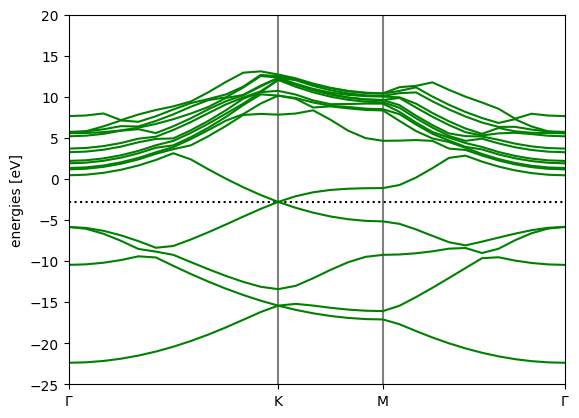

<Axes: ylabel='energies [eV]'>

In [9]:
bs_dft = calc_bands.band_structure()
bs_dft.plot(show=True, emax=20.0, emin=-25)


In [ ]:


calc_nscf_irred = GPAW(f'{seed}-nscf.gpw', txt=None)

sg = SpaceGroup.from_gpaw(calc_nscf_irred)
positions = sg.positions

proj_pz = Projection(
    position_num=positions,
    orbital='pz',
    spacegroup=sg,
    rotate_basis=True
)
proj_set = ProjectionsSet(projections=[proj_pz])


w90data = Wannier90data().from_gpaw(
    calculator=calc_nscf_irred,
    spin_channel=0,
    projections=proj_set,
    select_grid=(6,6,1),
    seedname="graphene-wb",
    irreducible=True,
    files=["amn", "mmn", "eig", "symmetrizer"],
    unitary_params=dict(error_threshold=0.1,
                        warning_threshold=0.01,
                        nbands_upper_skip=8),
)


typat used for spacegroup detection (accounting magmoms): [6 6]
finding num points from 1 projections
got irreducible=True, mp_grid=None, seedname=graphene, files=['amn', 'mmn', 'eig', 'symmetrizer'], read_npz_list=None, write_npz_list=None, projections=ProjectionsSet with 2 Wannier functions and 0 free variables
Projection 0.3333333333333333, 0.6666666666666666, 0.0:['pz'] with 2 Wannier functions on 2 points (1 per site), unk_grid=None, normalize=True
self.irreducible=True
mpgrid = [6 6 1], 7


/home/stepan/github/wannier-berri/wannierberri/w90files/w90data.py:191: UserWarning: Failed to read symmetrizer from graphene.symmetrizer.npz: [Errno 2] No such file or directory: 'graphene.symmetrizer.npz'
  warnings.warn(f"Failed to read symmetrizer from {fname}: {e}")


orbitals = ['pz']
calculating Wannier functions for pz at [[0.33333333 0.66666667 0.        ]
 [0.66666667 0.33333333 0.        ]]
D.shape [(7, 24, 2, 2)]
num_wann 2
D_wann_block_indices [[0 2]]
saving to graphene.symmetrizer.npz : 
Shells found with weights [7.66444094 1.37959937] and tolerance 5.552002161750444e-16
saving to graphene.bkvec.npz : 
saving to graphene.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 2 Wannier functions and 0 free variables
Projection 0.3333333333333333, 0.6666666666666666, 0.0:['pz'] with 2 Wannier functions on 2 points (1 per site)
unit cell volume = 128.92464760513099 
gk.shape=(807, 3), expgk.shape=(2, 807), wf.shape=(24, 807, 1), pos.shape=(2, 3)
projector on itself ((2, 2)): 
 [[ 1.297 -0.891]
 [-0.891  1.297]] 
gk.shape=(801, 3), expgk.shape=(2, 801), wf.shape=(24, 801, 1), pos.shape=(2, 3)
projector on itself ((2, 2)): 
 [[ 1.168 -0.687]
 [-0.687  1.168]] 
gk.shape=(835, 3), expgk.shape=(2, 835), wf.shape=(24, 835, 1), pos.shap

In [55]:
w90data.wannierise(
    # froz_min=-2,
    # froz_max=-1,
    num_iter=100,
    conv_tol=1e-10,
    frozen_states = {0:[1,], 2:[3,4]},
    print_progress_every=20,
    sitesym=True,
    localise=True
)

froz_min > froz_max, nothing will be frozen
kptirr =array([0, 1, 2, 3, 4, 5, 6]), ik=0, frozen_ik=[1]
kptirr =array([0, 1, 2, 3, 4, 5, 6]), ik=2, frozen_ik=[3, 4]
####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.710140831103    1.230000000000    0.000000000000   |     1.011884376567
  0.710140831103    1.230000000000   -0.000000000000   |     1.011884376567
----------------------------------------------------------------------------------------------------
 -0.000000000000    2.460000000000   -0.000000000000   |     2.023768753134 <- sum
                                          maximal spread =   1.011884376567
#################################################################################

/home/stepan/github/wannier-berri/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


####################################################################################################
Iteration 20 (from wannierizer)
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.710140831103    1.230000000000    0.000000000000   |     0.958224146412
  0.710140831103    1.230000000000    0.000000000000   |     0.958224146412
----------------------------------------------------------------------------------------------------
 -0.000000000000    2.460000000000    0.000000000000   |     1.916448292823 <- sum
                                          maximal spread =   0.958224146412
standard deviation = 0.000128534584123614
####################################################################################################
##################################################################################

In [56]:


from wannierberri.system.system_w90 import System_w90

system = System_w90(w90data=w90data, berry=True)



irreducible : True, symmetrize set to True
setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 2.13042249  1.23        0.        ]
 [-2.13042249  1.23        0.        ]
 [ 0.          0.         24.6       ]]
Number of wannier functions: 2
Number of R points: 51
Recommended size of FFT grid [6 6 1]


In [57]:


from wannierberri.evaluate_k import evaluate_k_path

kpoints = {
    'G': [0.0, 0.0, 0.0],
    'K': [1/3, 1/3, 0.0],
    'M': [0.5, 0.0, 0.0],
}

path_labels = "GKMG"

path , bands_wannier= evaluate_k_path(system, 
                                nodes=[kpoints[label] for label in path_labels],
                                labels=list(path_labels),
                                length=100,
                                return_path=True)  # length~=2pi/dk



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x76b7729005c0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x76b77282f770> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x76b7729005c0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 65 points and labels {0: 'G', 27: 'K', 41: 'M', 64: 'G'}
generating K_list
Done 
Done, sum of weights:65.0

#################################

/home/stepan/github/wannier-berri/wannierberri/run.py:187: UserWarning: ray package found, but ray is not initialized, running in serial mode
  warnings.warn("ray package found, but ray is not initialized, running in serial mode")
/home/stepan/github/wannier-berri/wannierberri/grid/path.py:165: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


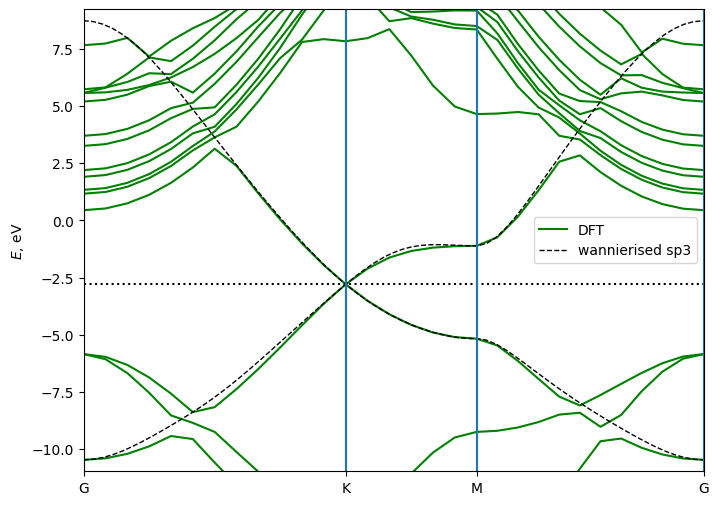

In [54]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
bs_dft.plot(show=False, emax=40.0, ax=ax, label="DFT")
bands_wannier.plot_path_fat(path=path,
                       label="wannierised sp3",
                        # linecolor="orange",
                        axes=ax,
                        close_fig=False,
                        show_fig=False,
                        kwargs_line=dict(linestyle='--', lw=1.0),
)
plt.show()